This analysis is on the wonderful [MovieLens 10M dataset](http://files.grouplens.org/datasets/movielens/ml-10m-README.html), which contains around 10 million ratings of 10,681 movies by 71,567 users.

I used [this list](http://www.timeout.com/london/film/the-50-best-christmas-movies) of the 50 best Christmas movies.

In [1]:
import lxml.html
from lxml.cssselect import CSSSelector

In [2]:
import requests

In [3]:
def get_title(node):
    h3_elem = node.cssselect('div.feature-item__text h3')[0]
    anchor_elem = h3_elem.cssselect('a')
    if len(anchor_elem) == 0:
        return h3_elem.text_content()
    else:
        return anchor_elem[0].text_content()

In [4]:
r = requests.get("http://www.timeout.com/london/film/the-50-best-christmas-movies")

In [5]:
tree = lxml.html.fromstring(r.text)

In [6]:
items_selector = CSSSelector('article.feature-item')
all_items = items_selector(tree)

h3_titles = [get_title(item) for item in all_items[0:50]]

In [7]:
h3_titles

['The Santa Clause (1994)',
 'Reindeer Games (2000)',
 'The Family Stone (2005)',
 'Love Actually (2003)',
 'Merry Christmas Mr Lawrence (1983)',
 u'\n                                            Joyeux No\xebl (2005)\n                                        ',
 '\n                                            Christmas in Connecticut (1945)\n                                        ',
 'The Polar Express (2004)',
 'A Christmas Story (1983)',
 'The Holiday (2006)',
 'Planes, Trains and Automobiles (1987)',
 'Lethal Weapon (1987)',
 'Ghostbusters II (1989)',
 '\n                                            Prancer (1989)\n                                        ',
 'Holiday Inn (1942)',
 'White Christmas (1954)',
 u'\n                                            Mickey\u2019s Christmas Carol (1983)\n                                        ',
 u'National Lampoon\u2019s Christmas Vacation (1989)',
 '\n                                            Babes In Toyland (1934)\n                         

In [8]:
titles = [t.replace('\n', '').strip() for t in h3_titles]

In [9]:
titles = [t.encode('utf8').replace('\xe2\x80\x99', '\'') for t in titles]

In [10]:
import re
for i, t in enumerate(titles):
    if re.match("^The", t):
        t = re.sub(r'^The ', '', t)
        titles[i] = t[:-7] + ", The" + t[-7:]

In [11]:
for i, t in enumerate(titles):
    if re.match("^A", t):
        t = re.sub(r'^A ', '', t)
        titles[i] = t[:-7] + ", A" + t[-7:]

In [12]:
titles[5] = titles[5].replace('Joyeux No\xc3\xabl (2005)', 
                              'Joyeux')

In [13]:
titles

['Santa Clause, The (1994)',
 'Reindeer Games (2000)',
 'Family Stone, The (2005)',
 'Love Actually (2003)',
 'Merry Christmas Mr Lawrence (1983)',
 'Joyeux',
 'Christmas in Connecticut (1945)',
 'Polar Express, The (2004)',
 'Christmas Story, A (1983)',
 'Holiday, The (2006)',
 'Planes, Trains and Automobiles (1987)',
 'Lethal Weapon (1987)',
 'Ghostbusters II (1989)',
 'Prancer (1989)',
 'Holiday Inn (1942)',
 'White Christmas (1954)',
 "Mickey's Christmas Carol (1983)",
 "National Lampoon's Christmas Vacation (1989)",
 'Babes In Toyland (1934)',
 "'R-Xmas (2001)",
 'Meet Me In St Louis (1944)',
 'About a Boy, A (2002)',
 'Christmas Evil (1980)',
 'Die Hard (1988)',
 'Die Hard 2 (1990)',
 'Christmas Carol, A (1938)',
 'While You Were Sleeping (1995)',
 'Arthur Christmas, A (2011)',
 'Trading Places (1983)',
 'Brazil (1985)',
 "Bridget Jones' Diary (2001)",
 'Nightmare Before Christmas, The (1993)',
 'Muppet Christmas Carol, The (1992)',
 'How The Grinch Stole Christmas (2000)',
 'Lon

In [14]:
f = open("christmas_movies.txt", "w")
f.write("\n".join(map(lambda x: str(x), titles)))
f.close()

In [ ]:
DROP TABLE IF EXISTS ratingsdata;
CREATE TABLE ratingsdata ( 
   userid INT, 
   itemid INT, 
   rating INT, 
   timestamp INT, 
   PRIMARY KEY (userid, itemid)); 

In [ ]:
DROP TABLE IF EXISTS movies;
CREATE TABLE movies ( 
   itemid INT PRIMARY KEY, 
   title TEXT, 
   genres TEXT,
   action INT DEFAULT 0,
   adventure INT DEFAULT 0,
   animation INT DEFAULT 0,
   childrens INT DEFAULT 0,
   comedy INT DEFAULT 0,
   crime INT DEFAULT 0,
   documentary INT DEFAULT 0,
   drama INT DEFAULT 0,
   fantasy INT DEFAULT 0,
   noir INT DEFAULT 0,
   horror INT DEFAULT 0,
   musical INT DEFAULT 0,
   mystery INT DEFAULT 0,
   romance INT DEFAULT 0,
   scifi INT DEFAULT 0,
   thriller INT DEFAULT 0,
   war INT DEFAULT 0,
   western INT DEFAULT 0);

In [ ]:
DROP TABLE IF EXISTS christmas;
CREATE TABLE christmas (
	name TEXT);

In [ ]:
CREATE INDEX usersdata_index ON ratingsdata (userid); 
CREATE INDEX itemsdata_index ON ratingsdata (itemid);

In [ ]:
LOAD DATA LOCAL INFILE '/Users/jburchell/Documents/MovieLens/ml-10M100K/ratings.dat' 
	INTO TABLE ratingsdata 
	FIELDS TERMINATED BY '::';
    
LOAD DATA LOCAL INFILE '/Users/jburchell/Documents/MovieLens/ml-10M100K/movies.dat' 
	INTO TABLE movies 
	FIELDS TERMINATED BY '::';
    
LOAD DATA LOCAL INFILE '/Users/jburchell/Documents/MovieLens/christmas_movies.txt' 
	INTO TABLE christmas;

In [ ]:
SELECT COUNT(name) 
FROM (
   SELECT * 
   FROM christmas 
   INNER JOIN movies
   ON UPPER(movies.title)
      LIKE CONCAT('%', UPPER(christmas.name), '%')
) AS counts;

In [15]:
from pandas import Series, DataFrame
import pandas as pd
import mysql.connector

cnx = mysql.connector.connect(user='Jodie', password='j0d1e',
                              host='192.168.99.100',
                              database='MovieLens', 
                              port = 32769)

In [40]:
# Average ratings for Christmas movies

query = ("""\
SELECT * 
FROM (
   SELECT movies.title AS "Title", AVG(ratingsdata.rating) AS avgr
   FROM movies
   INNER JOIN ratingsdata
   ON movies.itemid = ratingsdata.itemid
   WHERE movies.itemid IN (
      SELECT christmasids.itemid
      FROM movies
      INNER JOIN christmasids
         ON movies.itemid = christmasids.itemid)
   GROUP BY movies.title
) AS christmasratings
ORDER BY avgr DESC;
""")

cursor = cnx.cursor() 
cursor.execute(query)
df1 = DataFrame(cursor.fetchall(), 
               columns = ['Title', 'AverageRating'])

In [41]:
df1

,Title,AverageRating
0,"Christmas Story, A (1983)",4.1761
1,It's a Wonderful Life (1946),4.1568
2,Brazil (1985),4.1246
3,In Bruges (2008),4.1119
4,Kiss Kiss Bang Bang (2005),4.1001
5,Merry Christmas (Joyeux NoÃ«l) (2005),4.0465
6,Die Hard (1988),4.0295
7,Love Actually (2003),3.9936
8,"Charlie Brown Christmas, A (1965)",3.9250
9,"Christmas Carol, A (1938)",3.9021


([<matplotlib.axis.YTick at 0x108a22d10>,
 <a list of 10 Text yticklabel objects>)

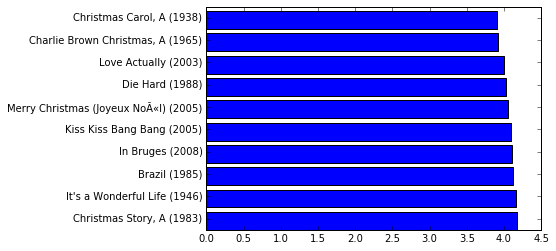

In [42]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

data = df1[:10]

x = np.arange(len(data))

plt.barh(x, data['AverageRating'])
plt.yticks(x + 0.5, data['Title'])

In [99]:
# Average ratings for Christmas movies Jan-Nov

query = ("""\
SELECT * 
FROM (
   SELECT movies.title AS "Title", AVG(ratingsdata.rating) AS avgr 
   FROM movies
   INNER JOIN ratingsdata
   ON movies.itemid = ratingsdata.itemid
   WHERE movies.itemid IN (
      SELECT christmasids.itemid
      FROM movies
      INNER JOIN christmasids
         ON movies.itemid = christmasids.itemid) 
   AND NOT MONTH(FROM_UNIXTIME(ratingsdata.timestamp)) = 12
   GROUP BY movies.title
) AS christmasratings
ORDER BY avgr DESC;
""")

cursor = cnx.cursor() 
cursor.execute(query)
NotDec = DataFrame(cursor.fetchall(), 
                   columns = ['Title', 'AverageRating'])

In [100]:
# Average ratings for Christmas movies in December

query = ("""\
SELECT * 
FROM (
   SELECT movies.title AS "Title", AVG(ratingsdata.rating) AS avgr 
   FROM movies
   INNER JOIN ratingsdata
   ON movies.itemid = ratingsdata.itemid
   WHERE movies.itemid IN (
      SELECT christmasids.itemid
      FROM movies
      INNER JOIN christmasids
         ON movies.itemid = christmasids.itemid) 
   AND MONTH(FROM_UNIXTIME(ratingsdata.timestamp)) = 12
   GROUP BY movies.title
) AS christmasratings
ORDER BY avgr DESC;
""")

cursor = cnx.cursor() 
cursor.execute(query)
Dec = DataFrame(cursor.fetchall(), 
                columns = ['Title', 'AverageRating'])

In [101]:
df2 = pd.merge(NotDec, Dec, left_on='Title', right_on='Title', how='outer')
df2['diff'] = df2['AverageRating_y'] - df2['AverageRating_x']
df2

,Title,AverageRating_x,AverageRating_y,diff
0,"Christmas Story, A (1983)",4.1686,4.2167,0.0481
1,It's a Wonderful Life (1946),4.1519,4.1914,0.0395
2,Brazil (1985),4.1278,4.1022,-0.0256
3,In Bruges (2008),4.1046,4.1964,0.0918
4,Kiss Kiss Bang Bang (2005),4.1021,4.0807,-0.0214
5,Merry Christmas (Joyeux NoÃ«l) (2005),4.0408,4.0800,0.0392
6,Die Hard (1988),4.0270,4.0498,0.0228
7,Love Actually (2003),4.0000,3.9422,-0.0578
8,"Charlie Brown Christmas, A (1965)",3.9653,3.6667,-0.2986
9,"Christmas Carol, A (1938)",3.8978,3.9250,0.0272


In [88]:
df3['AboveZero'] = df3.loc[:,'diff'] > 0

([<matplotlib.axis.YTick at 0x109d1f710>,
 <a list of 35 Text yticklabel objects>)

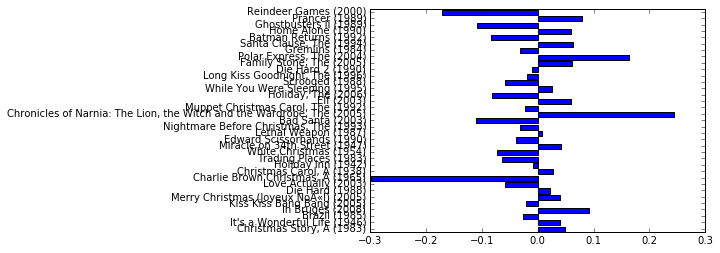

In [103]:
#x = np.arange(len(df3))

#df3['diff'] < 0

x = np.arange(len(df2))

plt.barh(x, df2['diff'])
plt.yticks(x + 0.5, df2['Title'])


In [45]:
## Average ratings by movie and year

query = ("""\
SELECT movies.title AS Title, 
    YEAR(FROM_UNIXTIME(ratingsdata.timestamp)) as Year,
	AVG(ratingsdata.rating) AS AverageRating
FROM movies
INNER JOIN ratingsdata
ON movies.itemid = ratingsdata.itemid
WHERE movies.itemid IN (
	SELECT christmasids.itemid
	FROM movies
	INNER JOIN christmasids
		ON movies.itemid = christmasids.itemid)
GROUP BY movies.title, Year;
""")

cursor = cnx.cursor() 
cursor.execute(query)
df4 = DataFrame(cursor.fetchall(), 
               columns = ['Title', 'Year', 
                          'AverageRating'])

In [46]:
df4

,Title,Year,AverageRating
0,Bad Santa (2003),2003,3.7547
1,Bad Santa (2003),2004,3.6827
2,Bad Santa (2003),2005,3.7913
3,Bad Santa (2003),2006,3.6699
4,Bad Santa (2003),2007,3.6276
5,Bad Santa (2003),2008,3.6834
6,Bad Santa (2003),2009,2.8000
7,Batman Returns (1992),1996,3.2126
8,Batman Returns (1992),1997,3.0481
9,Batman Returns (1992),1998,2.8114


In [63]:
## Genres of Christmas movies

query = ("""\
SELECT SUM(movies.action) AS Action, 
      SUM(movies.adventure) AS Adventure, 
      SUM(movies.animation) AS Animation,
      SUM(movies.childrens) AS Childrens, 
      SUM(movies.comedy) AS Comedy, 
      SUM(movies.crime) AS Crime,
      SUM(movies.documentary) AS Documentary, 
      SUM(movies.drama) AS Drama, 
      SUM(movies.fantasy) AS Fantasy,
      SUM(movies.noir) AS Noir, 
      SUM(movies.horror) AS Horror, 
      SUM(movies.musical) AS Musical,
      SUM(movies.mystery) AS Mystery, 
      SUM(movies.romance) AS Romance, 
      SUM(movies.scifi) AS SciFi,
      SUM(movies.thriller) AS Thriller, 
      SUM(movies.war) AS War, 
      SUM(movies.western) AS Western
FROM movies
WHERE movies.title IN (
   SELECT DISTINCT movies.title
   FROM movies
   LEFT JOIN ratingsdata
      ON movies.itemid = ratingsdata.itemid
   WHERE movies.itemid IN (
      SELECT christmasids.itemid
      FROM movies
      INNER JOIN christmasids
         ON movies.itemid = christmasids.itemid));
""")

cursor = cnx.cursor() 
cursor.execute(query)
df5 = DataFrame(cursor.fetchall(), 
               columns = ['Action', 'Adventure', 'Animation',
                          'Childrens', 'Comedy', 'Crime', 
                          'Documentary', 'Drama', 'Fantasy', 
                          'Noir', 'Horror', 'Musical', 'Mystery',
                          'Romance', 'SciFi', 'Thriller', 'War',
                          'Western'])

In [64]:
df5 = df5.transpose()

In [65]:
df5.columns = ['Count']

In [66]:
df5.sort_values(by = 'Count', ascending = 0)

,Count
Comedy,22
Drama,12
Fantasy,12
Romance,10
Action,9
Childrens,9
Thriller,6
Crime,5
Musical,4
Animation,3


([<matplotlib.axis.YTick at 0x108ecacd0>,
 <a list of 18 Text yticklabel objects>)

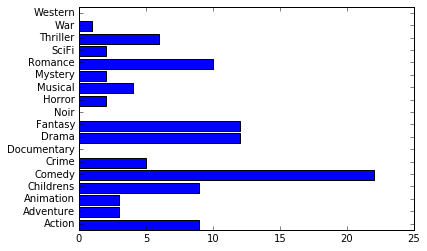

In [67]:
x = np.arange(len(df5))

plt.barh(x, df5['Count'])
plt.yticks(x + 0.5, df5.index)